# Week 13 - Day 4: Backpropagation and Optimization

## Learning Objectives
- Understand gradient descent and backpropagation mechanics
- Master different optimizers: SGD, Momentum, Adam, AdamW
- Implement learning rate schedules for better convergence
- Apply gradient clipping to prevent exploding gradients
- Compare optimizer performance on financial time series prediction

---

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
np.random.seed(42)
torch.manual_seed(42)

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


---
## Part 1: Gradient Descent Fundamentals

### 1.1 The Optimization Problem

In neural networks, we minimize a **loss function** $\mathcal{L}(\theta)$ with respect to parameters $\theta$:

$$\theta^* = \arg\min_\theta \mathcal{L}(\theta)$$

### 1.2 Gradient Descent Update Rule

The basic gradient descent update:

$$\theta_{t+1} = \theta_t - \eta \cdot \nabla_\theta \mathcal{L}(\theta_t)$$

Where:
- $\eta$ is the **learning rate**
- $\nabla_\theta \mathcal{L}$ is the **gradient** of the loss with respect to parameters

### 1.3 Backpropagation: The Chain Rule

For a composite function $\mathcal{L} = f(g(h(x)))$, the chain rule gives:

$$\frac{\partial \mathcal{L}}{\partial x} = \frac{\partial f}{\partial g} \cdot \frac{\partial g}{\partial h} \cdot \frac{\partial h}{\partial x}$$

In neural networks with layers:

$$\frac{\partial \mathcal{L}}{\partial W^{(l)}} = \frac{\partial \mathcal{L}}{\partial a^{(L)}} \cdot \frac{\partial a^{(L)}}{\partial a^{(L-1)}} \cdots \frac{\partial a^{(l+1)}}{\partial a^{(l)}} \cdot \frac{\partial a^{(l)}}{\partial W^{(l)}}$$

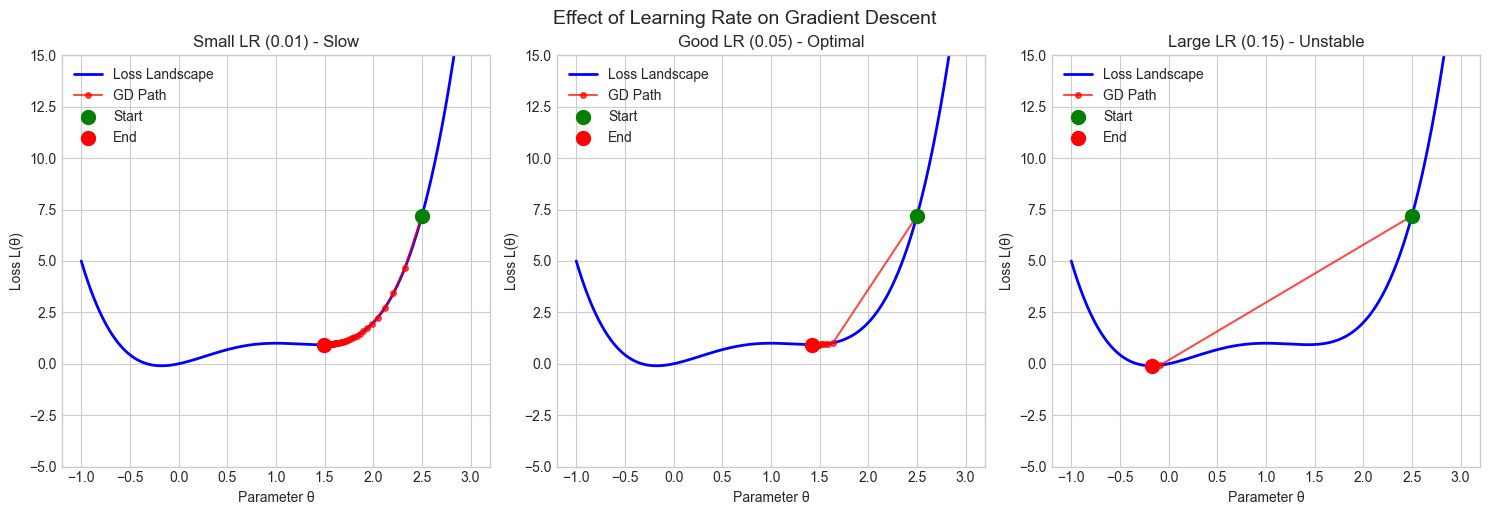

In [2]:
# Visualize Gradient Descent on a Simple Function
def loss_function(x):
    """A simple non-convex loss landscape"""
    return x**4 - 3*x**3 + 2*x**2 + x

def gradient(x):
    """Analytical gradient"""
    return 4*x**3 - 9*x**2 + 4*x + 1

# Gradient descent simulation
def gradient_descent_demo(start_x, lr, n_steps):
    x = start_x
    history = [(x, loss_function(x))]
    
    for _ in range(n_steps):
        grad = gradient(x)
        x = x - lr * grad
        history.append((x, loss_function(x)))
    
    return history

# Run with different learning rates
x_range = np.linspace(-1, 3, 500)
y_range = loss_function(x_range)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

learning_rates = [0.01, 0.05, 0.15]
titles = ['Small LR (0.01) - Slow', 'Good LR (0.05) - Optimal', 'Large LR (0.15) - Unstable']

for ax, lr, title in zip(axes, learning_rates, titles):
    ax.plot(x_range, y_range, 'b-', lw=2, label='Loss Landscape')
    
    history = gradient_descent_demo(2.5, lr, 50)
    xs, ys = zip(*history)
    
    ax.plot(xs, ys, 'ro-', markersize=4, alpha=0.7, label='GD Path')
    ax.scatter(xs[0], ys[0], c='green', s=100, zorder=5, label='Start')
    ax.scatter(xs[-1], ys[-1], c='red', s=100, zorder=5, label='End')
    
    ax.set_xlabel('Parameter θ')
    ax.set_ylabel('Loss L(θ)')
    ax.set_title(title)
    ax.legend()
    ax.set_ylim(-5, 15)

plt.tight_layout()
plt.suptitle('Effect of Learning Rate on Gradient Descent', y=1.02, fontsize=14)
plt.show()

---
## Part 2: Optimizers Deep Dive

### 2.1 Stochastic Gradient Descent (SGD)

**Vanilla SGD:**
$$\theta_{t+1} = \theta_t - \eta \cdot g_t$$

Where $g_t = \nabla_\theta \mathcal{L}(\theta_t; x^{(i)}, y^{(i)})$ is the gradient on a mini-batch.

**Pros:** Simple, low memory  
**Cons:** Noisy updates, can oscillate in ravines

---

### 2.2 SGD with Momentum

Adds a **velocity** term to smooth updates:

$$v_t = \beta v_{t-1} + g_t$$
$$\theta_{t+1} = \theta_t - \eta \cdot v_t$$

Where $\beta \in [0, 1)$ is the momentum coefficient (typically 0.9).

**Intuition:** Ball rolling downhill accumulates momentum.

---

### 2.3 Adam (Adaptive Moment Estimation)

Combines momentum with **adaptive learning rates**:

$$m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t \quad \text{(1st moment - mean)}$$
$$v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2 \quad \text{(2nd moment - variance)}$$

Bias correction:
$$\hat{m}_t = \frac{m_t}{1 - \beta_1^t}, \quad \hat{v}_t = \frac{v_t}{1 - \beta_2^t}$$

Update:
$$\theta_{t+1} = \theta_t - \eta \cdot \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}$$

**Default:** $\beta_1 = 0.9$, $\beta_2 = 0.999$, $\epsilon = 10^{-8}$

---

### 2.4 AdamW (Adam with Decoupled Weight Decay)

Fixes L2 regularization in Adam by **decoupling weight decay**:

$$\theta_{t+1} = \theta_t - \eta \left( \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon} + \lambda \theta_t \right)$$

Where $\lambda$ is the weight decay coefficient.

**Key Insight:** Standard L2 regularization doesn't work well with adaptive optimizers. AdamW properly regularizes.

ValueError: Unrecognized marker style '★'

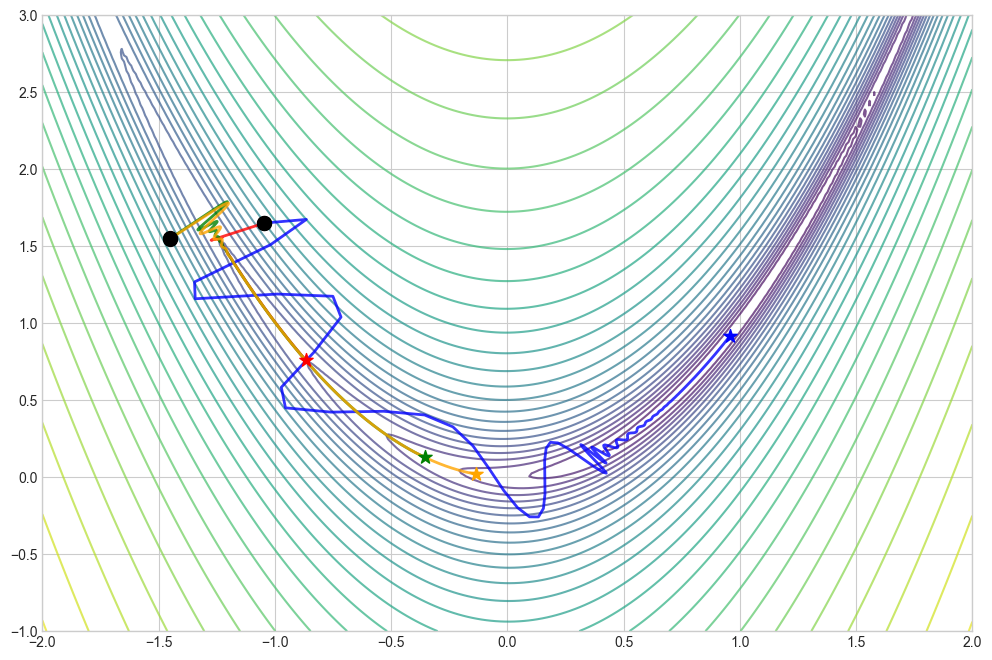

In [3]:
# Visualize optimizer behavior on Rosenbrock function (challenging optimization landscape)
def rosenbrock(x, y):
    """Rosenbrock function - classic optimization test"""
    return (1 - x)**2 + 100*(y - x**2)**2

class OptimizerVisualizer:
    def __init__(self):
        self.histories = {}
    
    def optimize_path(self, optimizer_name, start_point, lr, n_steps=500):
        """Track optimization path using PyTorch optimizers"""
        x = torch.tensor([start_point[0]], requires_grad=True, dtype=torch.float32)
        y = torch.tensor([start_point[1]], requires_grad=True, dtype=torch.float32)
        
        # Select optimizer
        if optimizer_name == 'SGD':
            optimizer = optim.SGD([x, y], lr=lr)
        elif optimizer_name == 'Momentum':
            optimizer = optim.SGD([x, y], lr=lr, momentum=0.9)
        elif optimizer_name == 'Adam':
            optimizer = optim.Adam([x, y], lr=lr)
        elif optimizer_name == 'AdamW':
            optimizer = optim.AdamW([x, y], lr=lr, weight_decay=0.01)
        
        history = []
        for _ in range(n_steps):
            optimizer.zero_grad()
            loss = (1 - x)**2 + 100*(y - x**2)**2
            loss.backward()
            optimizer.step()
            history.append((x.item(), y.item(), loss.item()))
        
        self.histories[optimizer_name] = history
        return history

# Create visualization
viz = OptimizerVisualizer()
start = (-1.5, 1.5)

# Different learning rates for fair comparison
viz.optimize_path('SGD', start, lr=0.001)
viz.optimize_path('Momentum', start, lr=0.001)
viz.optimize_path('Adam', start, lr=0.05)
viz.optimize_path('AdamW', start, lr=0.05)

# Plot contours and paths
fig, ax = plt.subplots(figsize=(12, 8))

x_grid = np.linspace(-2, 2, 200)
y_grid = np.linspace(-1, 3, 200)
X, Y = np.meshgrid(x_grid, y_grid)
Z = rosenbrock(X, Y)

# Log scale for better visualization
contour = ax.contour(X, Y, np.log(Z + 1), levels=30, cmap='viridis', alpha=0.7)

colors = {'SGD': 'red', 'Momentum': 'blue', 'Adam': 'green', 'AdamW': 'orange'}

for name, history in viz.histories.items():
    xs, ys, _ = zip(*history)
    ax.plot(xs, ys, '-', color=colors[name], label=name, linewidth=2, alpha=0.8)
    ax.scatter(xs[0], ys[0], c='black', s=100, zorder=5, marker='o')
    ax.scatter(xs[-1], ys[-1], c=colors[name], s=100, zorder=5, marker='*')

ax.scatter(1, 1, c='gold', s=200, marker='★', edgecolors='black', linewidth=2, 
           label='Global Minimum (1,1)', zorder=10)

ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.set_title('Optimizer Trajectories on Rosenbrock Function', fontsize=14)
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Compare convergence speed
fig, ax = plt.subplots(figsize=(10, 6))

for name, history in viz.histories.items():
    losses = [h[2] for h in history]
    ax.semilogy(losses, label=name, color=colors[name], linewidth=2)

ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('Loss (log scale)', fontsize=12)
ax.set_title('Optimizer Convergence Comparison', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print final losses
print("\nFinal Loss Values:")
print("-" * 30)
for name, history in viz.histories.items():
    final_loss = history[-1][2]
    print(f"{name:12s}: {final_loss:.6f}")

---
## Part 3: Learning Rate Schedules

### Why Schedule Learning Rates?

- **High LR early:** Fast exploration of loss landscape
- **Low LR later:** Fine-tuning near optimum

### 3.1 Step Decay
$$\eta_t = \eta_0 \cdot \gamma^{\lfloor t/s \rfloor}$$

### 3.2 Exponential Decay
$$\eta_t = \eta_0 \cdot \gamma^t$$

### 3.3 Cosine Annealing
$$\eta_t = \eta_{min} + \frac{1}{2}(\eta_{max} - \eta_{min})\left(1 + \cos\left(\frac{t}{T}\pi\right)\right)$$

### 3.4 Warmup + Decay
Linear warmup for first $T_w$ steps, then decay:
$$\eta_t = \begin{cases} \frac{t}{T_w} \eta_0 & t < T_w \\ \text{decay schedule} & t \geq T_w \end{cases}$$

### 3.5 One Cycle Policy
Triangle: increase LR to max, then decrease to minimum.

In [ ]:
# Visualize different learning rate schedules
def get_lr_schedule(scheduler_type, base_lr=0.1, epochs=100, steps_per_epoch=100):
    """Generate learning rate schedule"""
    # Dummy model and optimizer
    model = nn.Linear(10, 1)
    optimizer = optim.SGD(model.parameters(), lr=base_lr)
    
    if scheduler_type == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    elif scheduler_type == 'exponential':
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    elif scheduler_type == 'cosine':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0.001)
    elif scheduler_type == 'cosine_warmup':
        scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=20, T_mult=2)
    elif scheduler_type == 'one_cycle':
        scheduler = optim.lr_scheduler.OneCycleLR(
            optimizer, max_lr=base_lr, epochs=epochs, steps_per_epoch=steps_per_epoch
        )
    elif scheduler_type == 'reduce_plateau':
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
    
    lrs = []
    for epoch in range(epochs):
        for step in range(steps_per_epoch):
            lrs.append(optimizer.param_groups[0]['lr'])
            if scheduler_type == 'one_cycle':
                scheduler.step()
        if scheduler_type != 'one_cycle':
            if scheduler_type == 'reduce_plateau':
                # Simulate decreasing loss
                fake_loss = 1.0 / (epoch + 1)
                scheduler.step(fake_loss)
            else:
                scheduler.step()
    
    return lrs

# Plot schedules
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
schedules = ['step', 'exponential', 'cosine', 'cosine_warmup', 'one_cycle', 'reduce_plateau']
titles = ['Step Decay', 'Exponential Decay', 'Cosine Annealing', 
          'Cosine Warm Restarts', 'One Cycle', 'ReduceLROnPlateau']

for ax, schedule, title in zip(axes.flat, schedules, titles):
    lrs = get_lr_schedule(schedule)
    ax.plot(lrs, linewidth=2)
    ax.set_xlabel('Step')
    ax.set_ylabel('Learning Rate')
    ax.set_title(title)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Learning Rate Schedules', y=1.02, fontsize=14)
plt.show()

---
## Part 4: Gradient Clipping

### The Exploding Gradient Problem

In deep networks or RNNs, gradients can grow exponentially:
$$\frac{\partial \mathcal{L}}{\partial W_1} = \prod_{i=1}^{L} W_i \cdot \text{local gradients}$$

If $||W_i|| > 1$ for many layers, gradients explode!

### 4.1 Gradient Norm Clipping

If $||g|| > \tau$, scale the gradient:
$$g \leftarrow \frac{\tau}{||g||} \cdot g$$

### 4.2 Gradient Value Clipping

Clip each gradient element independently:
$$g_i \leftarrow \text{clip}(g_i, -\tau, \tau)$$

In [ ]:
# Demonstrate gradient clipping
def demonstrate_gradient_clipping():
    """Show effect of gradient clipping on training stability"""
    
    # Create a deep network prone to gradient issues
    class DeepNet(nn.Module):
        def __init__(self, depth=10):
            super().__init__()
            layers = []
            for _ in range(depth):
                layers.append(nn.Linear(50, 50))
                layers.append(nn.ReLU())
            layers.append(nn.Linear(50, 1))
            self.net = nn.Sequential(*layers)
            
            # Initialize with large weights to induce gradient issues
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.normal_(m.weight, std=0.5)
        
        def forward(self, x):
            return self.net(x)
    
    # Synthetic data
    X = torch.randn(1000, 50)
    y = torch.randn(1000, 1) * 10
    
    results = {}
    
    for clip_value, label in [(None, 'No Clipping'), (1.0, 'Clip Norm=1.0'), (5.0, 'Clip Norm=5.0')]:
        torch.manual_seed(42)
        model = DeepNet(depth=10)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.MSELoss()
        
        losses = []
        grad_norms = []
        
        for epoch in range(100):
            optimizer.zero_grad()
            output = model(X)
            loss = criterion(output, y)
            loss.backward()
            
            # Calculate gradient norm before clipping
            total_norm = 0
            for p in model.parameters():
                if p.grad is not None:
                    total_norm += p.grad.data.norm(2).item() ** 2
            total_norm = total_norm ** 0.5
            grad_norms.append(min(total_norm, 1000))  # Cap for visualization
            
            # Apply gradient clipping
            if clip_value is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            
            optimizer.step()
            losses.append(loss.item() if not np.isnan(loss.item()) else losses[-1] if losses else 100)
        
        results[label] = {'losses': losses, 'grad_norms': grad_norms}
    
    return results

results = demonstrate_gradient_clipping()

# Plot results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = {'No Clipping': 'red', 'Clip Norm=1.0': 'green', 'Clip Norm=5.0': 'blue'}

for label, data in results.items():
    axes[0].plot(data['losses'], label=label, color=colors[label], linewidth=2)
    axes[1].plot(data['grad_norms'], label=label, color=colors[label], linewidth=2, alpha=0.7)

axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss with Different Clipping')
axes[0].legend()
axes[0].set_ylim(0, min(200, max([max(d['losses']) for d in results.values()])))
axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Gradient Norm')
axes[1].set_title('Gradient Norms During Training')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Gradient clipping in practice - PyTorch methods
print("Gradient Clipping Methods in PyTorch:")
print("=" * 50)

# Example model
model = nn.Linear(10, 1)
optimizer = optim.Adam(model.parameters())

# Method 1: Clip by norm (most common)
print("\n1. Clip by Global Norm:")
print("   torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)")

# Method 2: Clip by value
print("\n2. Clip by Value:")
print("   torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=0.5)")

# Typical training loop with clipping
print("\n" + "=" * 50)
print("Typical Training Loop with Gradient Clipping:")
print("""  
for batch in dataloader:
    optimizer.zero_grad()
    output = model(batch)
    loss = criterion(output, target)
    loss.backward()
    
    # Clip gradients BEFORE optimizer.step()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    
    optimizer.step()
""")

---
## Part 5: Practical - Compare Optimizers on SPY Prediction

Let's build a neural network to predict SPY returns and compare how different optimizers perform.

### Task: Predict next-day returns using technical features

In [ ]:
# Download SPY data
print("Downloading SPY data...")
spy = yf.download('SPY', start='2015-01-01', end='2024-12-31', progress=False)

# Use Close prices
df = pd.DataFrame()
df['Close'] = spy['Close'].squeeze()
df['Return'] = df['Close'].pct_change()

print(f"Data shape: {df.shape}")
print(f"Date range: {spy.index[0].date()} to {spy.index[-1].date()}")
df.head()

In [ ]:
# Feature Engineering
def create_features(data, lookback=20):
    """Create technical features for prediction"""
    df = data.copy()
    
    # Price-based features
    for i in [1, 2, 3, 5, 10, 20]:
        df[f'return_{i}d'] = df['Close'].pct_change(i)
    
    # Moving averages
    for window in [5, 10, 20, 50]:
        df[f'sma_{window}'] = df['Close'].rolling(window).mean() / df['Close'] - 1
    
    # Volatility
    for window in [5, 10, 20]:
        df[f'vol_{window}'] = df['Return'].rolling(window).std()
    
    # Momentum
    df['momentum_10'] = df['Close'] / df['Close'].shift(10) - 1
    df['momentum_20'] = df['Close'] / df['Close'].shift(20) - 1
    
    # RSI
    delta = df['Return']
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / (loss + 1e-10)
    df['rsi'] = 100 - (100 / (1 + rs))
    df['rsi'] = (df['rsi'] - 50) / 50  # Normalize to [-1, 1]
    
    # Target: Next day return
    df['target'] = df['Return'].shift(-1)
    
    # Drop NaN
    df = df.dropna()
    
    return df

df_features = create_features(df)
print(f"Features created. Shape: {df_features.shape}")

# Feature columns
feature_cols = [col for col in df_features.columns if col not in ['Close', 'Return', 'target']]
print(f"Number of features: {len(feature_cols)}")
print(f"Features: {feature_cols}")

In [ ]:
# Prepare data for PyTorch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Split data (time-series aware - no shuffling)
train_size = int(len(df_features) * 0.7)
val_size = int(len(df_features) * 0.15)

train_data = df_features.iloc[:train_size]
val_data = df_features.iloc[train_size:train_size + val_size]
test_data = df_features.iloc[train_size + val_size:]

print(f"Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(train_data[feature_cols])
X_val = scaler.transform(val_data[feature_cols])
X_test = scaler.transform(test_data[feature_cols])

y_train = train_data['target'].values
y_val = val_data['target'].values
y_test = test_data['target'].values

# Scale targets (returns are small, helps training)
target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_scaled = target_scaler.transform(y_val.reshape(-1, 1)).flatten()
y_test_scaled = target_scaler.transform(y_test.reshape(-1, 1)).flatten()

# Convert to tensors
X_train_t = torch.FloatTensor(X_train)
y_train_t = torch.FloatTensor(y_train_scaled)
X_val_t = torch.FloatTensor(X_val)
y_val_t = torch.FloatTensor(y_val_scaled)
X_test_t = torch.FloatTensor(X_test)
y_test_t = torch.FloatTensor(y_test_scaled)

# Create DataLoaders
batch_size = 64
train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print(f"\nInput dimension: {X_train.shape[1]}")

In [ ]:
# Define the Neural Network
class ReturnPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dims=[64, 32, 16]):
        super().__init__()
        
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.2)
            ])
            prev_dim = hidden_dim
        
        layers.append(nn.Linear(prev_dim, 1))
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x).squeeze()

# Test model
test_model = ReturnPredictor(X_train.shape[1])
print(test_model)
print(f"\nTotal parameters: {sum(p.numel() for p in test_model.parameters()):,}")

In [ ]:
# Training function with comprehensive tracking
def train_model(optimizer_name, lr, epochs=100, weight_decay=0, use_scheduler=False, clip_grad=None):
    """
    Train model with specified optimizer and settings
    """
    torch.manual_seed(42)
    model = ReturnPredictor(X_train.shape[1]).to(device)
    criterion = nn.MSELoss()
    
    # Select optimizer
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'Momentum':
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Learning rate scheduler
    scheduler = None
    if use_scheduler:
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=lr/100)
    
    history = {
        'train_loss': [],
        'val_loss': [],
        'lr': [],
        'grad_norm': []
    }
    
    X_val_device = X_val_t.to(device)
    y_val_device = y_val_t.to(device)
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        epoch_grad_norm = 0
        n_batches = 0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            
            # Track gradient norm
            total_norm = 0
            for p in model.parameters():
                if p.grad is not None:
                    total_norm += p.grad.data.norm(2).item() ** 2
            epoch_grad_norm += total_norm ** 0.5
            
            # Gradient clipping
            if clip_grad is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
            
            optimizer.step()
            epoch_loss += loss.item()
            n_batches += 1
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_output = model(X_val_device)
            val_loss = criterion(val_output, y_val_device).item()
        
        history['train_loss'].append(epoch_loss / n_batches)
        history['val_loss'].append(val_loss)
        history['lr'].append(optimizer.param_groups[0]['lr'])
        history['grad_norm'].append(epoch_grad_norm / n_batches)
        
        if scheduler:
            scheduler.step()
    
    # Final evaluation
    model.eval()
    with torch.no_grad():
        test_pred = model(X_test_t.to(device)).cpu().numpy()
    
    return model, history, test_pred

In [ ]:
# Compare optimizers
print("Training models with different optimizers...")
print("=" * 60)

optimizer_configs = [
    ('SGD', 0.01, 0),
    ('Momentum', 0.01, 0),
    ('Adam', 0.001, 0),
    ('AdamW', 0.001, 0.01),
]

results = {}
epochs = 100

for opt_name, lr, wd in optimizer_configs:
    print(f"\nTraining with {opt_name} (lr={lr}, wd={wd})...")
    model, history, predictions = train_model(
        opt_name, lr, epochs=epochs, weight_decay=wd, use_scheduler=True, clip_grad=1.0
    )
    results[opt_name] = {
        'model': model,
        'history': history,
        'predictions': predictions
    }
    print(f"  Final train loss: {history['train_loss'][-1]:.6f}")
    print(f"  Final val loss: {history['val_loss'][-1]:.6f}")

print("\n" + "=" * 60)
print("Training complete!")

In [ ]:
# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

colors = {'SGD': 'red', 'Momentum': 'blue', 'Adam': 'green', 'AdamW': 'orange'}

# Training Loss
ax = axes[0, 0]
for name, data in results.items():
    ax.plot(data['history']['train_loss'], label=name, color=colors[name], linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Training Loss (MSE)')
ax.set_title('Training Loss Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

# Validation Loss
ax = axes[0, 1]
for name, data in results.items():
    ax.plot(data['history']['val_loss'], label=name, color=colors[name], linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Validation Loss (MSE)')
ax.set_title('Validation Loss Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

# Learning Rate
ax = axes[1, 0]
for name, data in results.items():
    ax.plot(data['history']['lr'], label=name, color=colors[name], linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Learning Rate')
ax.set_title('Learning Rate Schedule (Cosine Annealing)')
ax.legend()
ax.grid(True, alpha=0.3)

# Gradient Norms
ax = axes[1, 1]
for name, data in results.items():
    ax.plot(data['history']['grad_norm'], label=name, color=colors[name], linewidth=2, alpha=0.7)
ax.set_xlabel('Epoch')
ax.set_ylabel('Average Gradient Norm')
ax.set_title('Gradient Norms During Training')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Optimizer Comparison on SPY Return Prediction', y=1.02, fontsize=14)
plt.show()

In [ ]:
# Evaluate predictions - Directional Accuracy and Sharpe Ratio
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_predictions(y_true, y_pred_scaled, target_scaler):
    """Evaluate model predictions"""
    # Inverse transform predictions
    y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    
    # Regression metrics
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Directional accuracy
    direction_correct = np.mean(np.sign(y_true) == np.sign(y_pred))
    
    # Simple trading strategy: long if predicted return > 0
    strategy_returns = np.sign(y_pred) * y_true
    sharpe = np.sqrt(252) * strategy_returns.mean() / (strategy_returns.std() + 1e-10)
    
    return {
        'MSE': mse,
        'MAE': mae,
        'R2': r2,
        'Direction_Acc': direction_correct,
        'Strategy_Sharpe': sharpe,
        'predictions': y_pred
    }

# Evaluate all optimizers
print("\n" + "=" * 80)
print("MODEL EVALUATION ON TEST SET")
print("=" * 80)

eval_results = {}
for name, data in results.items():
    eval_results[name] = evaluate_predictions(y_test, data['predictions'], target_scaler)

# Create comparison table
comparison_df = pd.DataFrame({
    name: {
        'MSE (×10⁵)': r['MSE'] * 1e5,
        'MAE (%)': r['MAE'] * 100,
        'R²': r['R2'],
        'Direction Acc (%)': r['Direction_Acc'] * 100,
        'Strategy Sharpe': r['Strategy_Sharpe']
    }
    for name, r in eval_results.items()
}).T

print(comparison_df.round(4))

# Highlight best optimizer
best_sharpe = comparison_df['Strategy Sharpe'].idxmax()
best_accuracy = comparison_df['Direction Acc (%)'].idxmax()
print(f"\n✓ Best Strategy Sharpe: {best_sharpe}")
print(f"✓ Best Direction Accuracy: {best_accuracy}")

In [ ]:
# Visualize cumulative returns of strategies
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Cumulative returns
ax = axes[0]
buy_hold_cum = (1 + y_test).cumprod()
ax.plot(buy_hold_cum, label='Buy & Hold SPY', color='black', linewidth=2, linestyle='--')

for name, r in eval_results.items():
    strategy_returns = np.sign(r['predictions']) * y_test
    strategy_cum = (1 + strategy_returns).cumprod()
    ax.plot(strategy_cum, label=f'{name} Strategy', color=colors[name], linewidth=2)

ax.set_xlabel('Trading Days')
ax.set_ylabel('Cumulative Return')
ax.set_title('Strategy Cumulative Returns (Test Period)')
ax.legend()
ax.grid(True, alpha=0.3)

# Prediction distribution
ax = axes[1]
for name, r in eval_results.items():
    ax.hist(r['predictions'], bins=50, alpha=0.5, label=name, color=colors[name])

ax.axvline(0, color='black', linestyle='--', linewidth=2)
ax.set_xlabel('Predicted Return')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Predicted Returns')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## Part 6: Best Practices Summary

### Optimizer Selection Guide

| Optimizer | Best For | Learning Rate | Notes |
|-----------|----------|---------------|-------|
| **SGD** | Final fine-tuning, convex problems | 0.01-0.1 | Simple, may need momentum |
| **Momentum** | General training | 0.01-0.1 | Add momentum=0.9 |
| **Adam** | Most deep learning tasks | 0.001-0.01 | Good default choice |
| **AdamW** | When using weight decay | 0.001-0.01 | Better generalization |

### Hyperparameter Recommendations

1. **Learning Rate:** Start with Adam's default (0.001), adjust based on loss curves
2. **Weight Decay:** 0.01 for AdamW, 0.0001-0.001 for others
3. **Gradient Clipping:** Use max_norm=1.0 for RNNs and deep networks
4. **Scheduler:** Cosine annealing or OneCycleLR for most tasks

### Financial ML Specific Tips

- **AdamW + Cosine Annealing** often works best for return prediction
- Use **gradient clipping** to handle volatile market regimes
- **Warmup** helps when training on limited financial data
- Monitor **directional accuracy** not just MSE for trading models

In [ ]:
# Final summary
print("\n" + "=" * 60)
print("DAY 4 SUMMARY: BACKPROPAGATION & OPTIMIZATION")
print("=" * 60)

print("""
KEY TAKEAWAYS:

1. GRADIENT DESCENT
   • Update rule: θ = θ - η∇L(θ)
   • Learning rate η controls step size
   • Too small → slow; Too large → unstable

2. OPTIMIZERS
   • SGD: Simple, needs tuning
   • Momentum: Smooths updates, faster convergence
   • Adam: Adaptive LR, great default
   • AdamW: Proper weight decay for regularization

3. LEARNING RATE SCHEDULES
   • Cosine Annealing: Smooth decay, good results
   • OneCycleLR: Fast training with super-convergence
   • Warmup: Stabilizes early training

4. GRADIENT CLIPPING
   • Prevents exploding gradients
   • Essential for RNNs and deep networks
   • Use max_norm=1.0 as starting point

5. FINANCIAL ML INSIGHTS
   • AdamW often outperforms Adam
   • Direction accuracy matters more than MSE
   • Combine optimizer choice with proper regularization
""")

print("\n✅ Day 4 Complete!")
print("Next: Day 5 - Regularization Techniques (Dropout, BatchNorm, L1/L2)")